In [270]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration raw data

In [2]:
df=pd.read_json("/Users/David/code/Clementinelalande/marbotic/raw_data/export_23-5_minified.json")

In [79]:
df.shape

(1320229, 16)

In [80]:
df.columns

Index(['city', 'client_event_time', 'country', 'device_model', 'event_id',
       'event_type', 'is_attribution_event', 'language', 'os_version',
       'region', 'session_id', 'start_version', 'user_creation_time',
       'user_id', 'user_properties', 'event_properties'],
      dtype='object')

In [81]:
df.event_type.unique()

array(['[Activity] Good Answer', '[Activity] Wrong Answer',
       '[Activity] Stop', '[Activity] Start', '[Action] Click',
       '[Scene] Leave', '[Scene] Enter', '[Game] Pause',
       '[Scaffolding] Scaffolding', '[Game] Start', '[Error] Error',
       '[Game] Stop', '[OB] CommPreview', '[OB] DoYouHaveKit',
       '[OB] HasKitYes', '[OB] Email', '[OB] VerifCode',
       '[Activation] Game', '[OB] HasKitNo', '[OB] DiscoverTrial',
       '[OB] ClickTrial', '[Account] Sign In', '[Profile] Create',
       '[Profile] Update', '[OB] ProductSelection', '[OB] ProductHelp',
       '[OB] Type', '[Account] Sign Up', '[OB] ProfileName',
       '[OB] ProfileBirthdate', '[Activation] New Activation',
       '[Activation] Product', '[Activation] Piece', '[OB] Success',
       '[OB] ProductActivation', '[Scaffolding] Reset', '[OB] TrialStart',
       '[Account] Update Request', '[Profile] Delete', '[Popup] Open',
       '[Popup] Close', '[Account] Update Success', '[Account] Sign Out',
       '[Pr

In [82]:
df.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,user_properties,event_properties
0,Dallas,2022-03-01 00:57:25.903,United States,"iPad13,4",1110,[Activity] Good Answer,False,English,15.3,Texas,1646095346396,1.0.7,2021-12-28 01:29:38.094,67531,"{'Newsletter': 'False', 'Products': ['Smart Le...","{'[Activity] Name': 'LinePanties', '[Activity]..."
1,Dallas,2022-03-01 00:57:41.878,United States,"iPad13,4",1111,[Activity] Wrong Answer,False,English,15.3,Texas,1646095346396,1.0.7,2021-12-28 01:29:38.094,67531,"{'Newsletter': 'False', 'Products': ['Smart Le...","{'[Activity] Name': 'LinePanties', '[Activity]..."
2,Toronto,2022-03-01 00:57:28.175,Canada,"iPad12,1",1430,[Activity] Stop,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.2', '[Game] Code': 'Mar..."
3,Toronto,2022-03-01 00:57:28.177,Canada,"iPad12,1",1431,[Activity] Start,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.3', '[Game] Code': 'Mar..."
4,Toronto,2022-03-01 00:57:38.278,Canada,"iPad12,1",1432,[Activity] Stop,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.3', '[Game] Code': 'Mar..."


In [109]:
df.event_properties[4]

{'[Activity] Name': '1.3',
 '[Game] Code': 'Marbotic',
 '[Time] Spent': 10,
 '[Scene] Name': 'Counting_Home',
 '[Profile] Age (days)': 2423,
 '[Game] Language': 'en_US',
 '[Activity] Solved': False,
 '[Scaffolding] Level': 11,
 '[Scene] Section': 'UP100'}

In [130]:
df.user_properties[4]

{'Newsletter': 'True',
 'Products': ['Smart Letters', 'Smart Numbers'],
 'Pieces': ['Uppercase Letters', 'Numbers'],
 'Language': 'English',
 'Type': 'Parent',
 'Country': 'CA',
 'Games': ['Marbotic Numbers',
  'Marbotic Letters',
  'Alphamonster',
  'Vocabubble',
  'Bla Bla Box',
  'Lil Reader',
  'Up To 100',
  '10 Fingers',
  'More Or Less',
  'Marbotic']}

In [83]:
user_properties_df=df.copy()

In [84]:
user_properties=user_properties_df[["user_id","user_properties"]]

# Import Dataframe with a query

## Connexion à Google Query

In [85]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=PoQsXFrUUsLui0bniQSz9njix6vkmV&access_type=offline&code_challenge=S3iaAqXEe7U5N46YKdeJCKShEw-o-S2tI7TMNTfuXWM&code_challenge_method=S256


You are now logged in as [david.periers@gmail.com].
Your current project is [marbotic].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [86]:
!gcloud projects list

PROJECT_ID              NAME              PROJECT_NUMBER
marbotic                Marbotic          566474310042
symmetric-curve-346916  My First Project  175516577791
wagon-bootcamp-346916   Wagon bootcamp    697736453840


In [87]:
!gcloud config set project marbotic

Updated property [core/project].


In [88]:
!bq ls

/usr/local/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/platform/bq/bq.py:41: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
     datasetId      
 ------------------ 
  marbotic_dataset  


In [89]:
!cat credentials

cat: credentials: No such file or directory


## Fonction extract with a query

In [14]:
from google.oauth2 import service_account

def extract():
    # Construct a BigQuery client object.

    key_path = "/Users/David/code/dperiers/GITHUB_NICKNAME/gcp/marbotic-587600c2c13f.json"

    credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    
    client = bigquery.Client(project="marbotic", credentials=credentials)

    query = """
        SELECT *
        FROM `marbotic.marbotic_dataset.events`
      
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [213]:
extract()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id
0,None,2022-05-12 21:28:00.367000+00:00,United States,"iPad8,11",3135,[Toast] Appear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307980
1,None,2022-05-12 21:28:05.614000+00:00,United States,"iPad8,11",3138,[Toast] Disappear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307983
2,None,2022-05-12 09:13:47.702000+00:00,Germany,iPad Pro,2480,[OB] ProfileName,False,German,15.4.1,Baden-Württemberg,1652346694954,1.0.1,2021-01-19 12:01:58.046000+00:00,52773,1312163
3,Zug,2022-05-13 06:39:47.474000+00:00,Switzerland,"iPad11,6",3,[Activation] Game,False,English,15.4.1,Zug,1652423984674,4.2.2,2021-11-09 10:31:37.463000+00:00,0,1317850
4,Urzy,2022-05-12 06:29:04.245000+00:00,France,iPad 6,1472,[Toast] Appear,False,French,15.3.1,Nièvre,1652336940411,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,1310560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320224,Clamecy,2022-03-29 12:58:32.689000+00:00,France,iPad 6,288,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557461195,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,572933
1320225,Clamecy,2022-03-29 13:00:37.189000+00:00,France,iPad 6,178,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,572946
1320226,Clamecy,2022-03-29 13:06:35.939000+00:00,France,iPad 6,213,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,573080
1320227,Clamecy,2022-03-29 13:04:33.402000+00:00,France,iPad 6,202,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,573170


# Exploration Marbotic User ID file

In [ ]:
test=pd.DataFrame(columns=["a","b"])
test

In [3]:
data=pd.read_csv("/Users/David/code/Clementinelalande/marbotic/raw_data/users_info_202206071551.csv",sep=";")

In [4]:
data.head()

,User id,Country,Language,News letter,Type,Attribution,Games,Products,Pieces,Purchases
0,59707,MX,English,True,Parent,PLU,"[""10 Fingers"",""Marbotic Letters"",""Marbotic Num...","[""Smart Kit"",""Smart Numbers"",""Nordic Kit""]","[""Nordic Letters"",""Numbers"",""Uppercase Letters""]",NaN
1,61748,NZ,English,False,Educator,ELU,"[""Marbotic Letters"",""Vocabubble"",""10 Fingers"",...","[""Smart Letters"",""Smart Numbers""]","[""Numbers"",""Uppercase Letters""]",NaN
2,54834,CA,English,True,Parent,PLU,"[""Sesame Street Numbers""]",NaN,NaN,NaN
3,69202,US,English,False,Parent,PLU,"[""Marbotic""]","[""Deluxe Learning Kit""]","[""Lowercase Letters"",""Numbers""]",NaN
4,67754,CA,English,True,Parent,PLU,"[""Marbotic""]","[""Smart Kit""]","[""Numbers"",""Uppercase Letters""]",NaN


In [5]:
data.shape

(13679, 10)

In [6]:
len(data["User id"].unique())

12858

In [8]:
len(data["Attribution"].unique())

14

# WAU table creation

## Load data

In [241]:
raw_data=extract()

In [242]:
raw_data.shape

(1320229, 15)

In [243]:
len(raw_data.id.unique())

1320229

In [244]:
raw_data.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id
0,None,2022-05-12 21:28:00.367000+00:00,United States,"iPad8,11",3135,[Toast] Appear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307980
1,None,2022-05-12 21:28:05.614000+00:00,United States,"iPad8,11",3138,[Toast] Disappear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307983
2,None,2022-05-12 09:13:47.702000+00:00,Germany,iPad Pro,2480,[OB] ProfileName,False,German,15.4.1,Baden-Württemberg,1652346694954,1.0.1,2021-01-19 12:01:58.046000+00:00,52773,1312163
3,Zug,2022-05-13 06:39:47.474000+00:00,Switzerland,"iPad11,6",3,[Activation] Game,False,English,15.4.1,Zug,1652423984674,4.2.2,2021-11-09 10:31:37.463000+00:00,0,1317850
4,Urzy,2022-05-12 06:29:04.245000+00:00,France,iPad 6,1472,[Toast] Appear,False,French,15.3.1,Nièvre,1652336940411,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,1310560


In [245]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320229 entries, 0 to 1320228
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype              
---  ------                --------------    -----              
 0   city                  1305842 non-null  object             
 1   client_event_time     1320229 non-null  datetime64[ns, UTC]
 2   country               1320229 non-null  object             
 3   device_model          1320229 non-null  object             
 4   event_id              1320229 non-null  int64              
 5   event_type            1320229 non-null  object             
 6   is_attribution_event  1320229 non-null  bool               
 7   language              1320229 non-null  object             
 8   os_version            1320229 non-null  object             
 9   region                1308214 non-null  object             
 10  session_id            1320229 non-null  int64              
 11  start_version         1320229 non-nul

## Compute Weekly active users

In [246]:
def get_week(x):
    return x.isocalendar()[1]

In [247]:
def get_year(x):
    return x.isocalendar()[0]

In [248]:
data=raw_data[["user_id","client_event_time"]].copy()
data["week2022"]=data["client_event_time"].map(lambda x: x.isocalendar()[1])
data.head()


,user_id,client_event_time,week2022
0,71150,2022-05-12 21:28:00.367000+00:00,19
1,71150,2022-05-12 21:28:05.614000+00:00,19
2,52773,2022-05-12 09:13:47.702000+00:00,19
3,0,2022-05-13 06:39:47.474000+00:00,19
4,70756,2022-05-12 06:29:04.245000+00:00,19


In [249]:
data["client_event_time"][0].isocalendar()

(2022, 19, 4)

In [250]:
#number of unique users
f"number of unique users: {len(data.user_id.unique())}"


'number of unique users: 2627'

In [251]:
logs=data.week2022.unique()
logs.sort()
logs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 22])

In [252]:
start_timestamp=data["client_event_time"].min()
end_timestamp=data["client_event_time"].max()
print(f"start_timestamp: {start_timestamp}")
print(f"end_timestamp: {end_timestamp}")

start_timestamp: 2022-01-07 02:56:28.793000+00:00
end_timestamp: 2022-06-05 23:13:18.926000+00:00


In [253]:
categories=[(i) for i in data.week2022.unique()]
categories.sort()
categories=np.array(categories)

In [254]:
np.array(categories)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 22])

In [255]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


ohe = OneHotEncoder(sparse = False) # Instantiate encoder

ohe.fit(data[["week2022"]]) #Fit encoder
headers=np.array([f"W{i}" for i in ohe.categories_[0].tolist()]) #Format header of OHE columns

data_encoded = ohe.transform(data[['week2022']]) # Encode week number
data_encoded=pd.DataFrame(data_encoded, columns=headers) #convert to DataFrame

wau=data[["user_id"]].copy() #concatenate user_id and OHE columns
wau[headers]=data_encoded[headers]

wau=wau.groupby(by="user_id").sum() #Group by unique user_id
wau

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W22
user_id,,,,,,,,,,,,,,,,,,,,
0,10.0,0.0,11.0,3.0,0.0,10.0,24.0,11.0,3056.0,2769.0,2554.0,3265.0,4138.0,3703.0,3514.0,5306.0,93138.0,2121.0,1478.0,0.0
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,16.0,0.0,10.0,4.0,3.0,0.0,0.0,0.0
453,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0
73185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0
73188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0,0.0


## Compute maturity cohorts

In [256]:
print(raw_data[["user_creation_time"]].min())
print(raw_data[["user_creation_time"]].max())
print(raw_data[["client_event_time"]].min())
print(raw_data[["client_event_time"]].max())

user_creation_time   2020-08-26 14:45:01.954000+00:00
dtype: datetime64[ns, UTC]
user_creation_time   2022-05-13 09:44:46.210000+00:00
dtype: datetime64[ns, UTC]
client_event_time   2022-01-07 02:56:28.793000+00:00
dtype: datetime64[ns, UTC]
client_event_time   2022-06-05 23:13:18.926000+00:00
dtype: datetime64[ns, UTC]


In [257]:
#Create a DataFrame for cochorts
cohorts=raw_data[["user_id","client_event_time","user_creation_time","id"]].copy()

In [258]:
#Map creation_index Year-Month index
cohorts["creation_index"]=cohorts["user_creation_time"].map(lambda x: f"Y{get_year(x)}-W{get_week(x)}")

In [259]:
# Calculate difference in months
        
cohorts["week_diff"] = (cohorts["client_event_time"]-cohorts["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

In [280]:
a=cohorts["creation_index"].unique()
a.sort()
a

array(['Y2020-W35', 'Y2020-W38', 'Y2020-W39', 'Y2020-W40', 'Y2020-W41',
       'Y2020-W42', 'Y2020-W43', 'Y2020-W44', 'Y2020-W45', 'Y2020-W46',
       'Y2020-W47', 'Y2020-W48', 'Y2020-W49', 'Y2020-W50', 'Y2020-W51',
       'Y2020-W52', 'Y2020-W53', 'Y2021-W1', 'Y2021-W10', 'Y2021-W11',
       'Y2021-W12', 'Y2021-W13', 'Y2021-W14', 'Y2021-W15', 'Y2021-W16',
       'Y2021-W17', 'Y2021-W18', 'Y2021-W19', 'Y2021-W2', 'Y2021-W20',
       'Y2021-W21', 'Y2021-W22', 'Y2021-W23', 'Y2021-W24', 'Y2021-W25',
       'Y2021-W26', 'Y2021-W27', 'Y2021-W28', 'Y2021-W29', 'Y2021-W3',
       'Y2021-W30', 'Y2021-W31', 'Y2021-W32', 'Y2021-W33', 'Y2021-W34',
       'Y2021-W35', 'Y2021-W36', 'Y2021-W37', 'Y2021-W38', 'Y2021-W39',
       'Y2021-W4', 'Y2021-W40', 'Y2021-W41', 'Y2021-W42', 'Y2021-W43',
       'Y2021-W44', 'Y2021-W45', 'Y2021-W46', 'Y2021-W47', 'Y2021-W48',
       'Y2021-W49', 'Y2021-W5', 'Y2021-W50', 'Y2021-W51', 'Y2021-W52',
       'Y2021-W6', 'Y2021-W7', 'Y2021-W8', 'Y2021-W9', 'Y2022-W1',
  

In [287]:
cohorts[cohorts["creation_index"]=="Y2020-W35"].

1

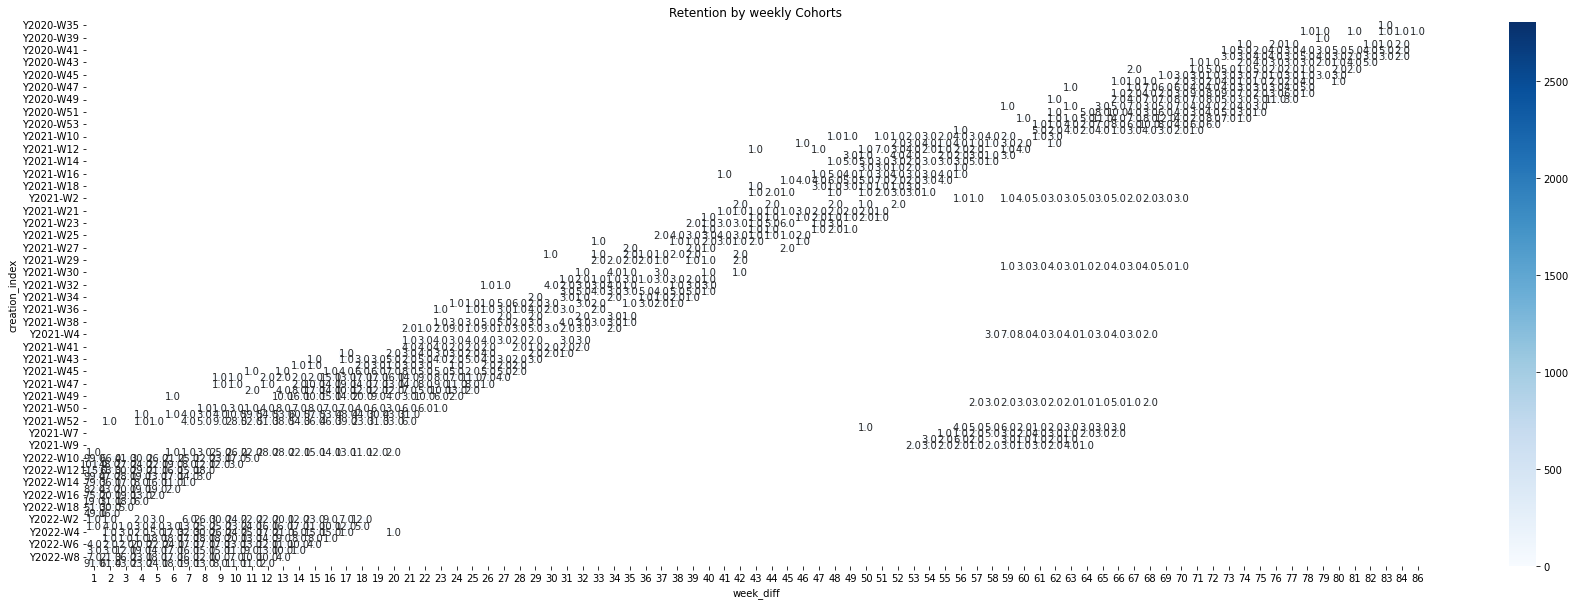

In [288]:
grouping = cohorts.groupby(['creation_index', 'week_diff'])

# Count the number of unique values per user_id

cohort_data = grouping['user_id'].apply(pd.Series.nunique).reset_index()

# Create a pivot

cohort_counts = cohort_data.pivot(index='creation_index', columns='week_diff', values='user_id')

# Select the first column and store it to cohort_sizes

cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows

retention = cohort_counts.divide(cohort_sizes, axis=0)*100
                                  

plt.figure(figsize=(30,10))

# Add a title

plt.title('Retention by weekly Cohorts')

# Create the heatmap

sns.heatmap(data=retentionb,
annot = True,
cmap = "Blues",
vmin = 0.0,
vmax = list(retention.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
           )
plt.show();

### Maturity table FY22

### Maturity table by weeks

In [291]:
#Create a DataFrame for cochorts
cohorts_FY22=raw_data[["user_id","client_event_time","user_creation_time","id"]].copy()

In [293]:
#Map creation_index Year-Month index
cohorts_FY22["creation_year"]=cohorts_FY22["user_creation_time"].map(lambda x: get_year(x))
cohorts_FY22["creation_week"]=cohorts_FY22["user_creation_time"].map(lambda x: get_week(x))
cohorts_FY22=cohorts_FY22[cohorts_FY22["creation_year"]==2022]

In [303]:
# Calculate difference in months
        
cohorts_FY22["week_diff"] = (cohorts_FY22["client_event_time"]-cohorts_FY22["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

1

In [311]:
cohorts_FY22["user_id"].nunique

<bound method IndexOpsMixin.nunique of 0          71150
1          71150
4          70756
5          70756
6          70756
           ...  
1320224    70756
1320225    70756
1320226    70756
1320227    70756
1320228    70756
Name: user_id, Length: 755771, dtype: int64>

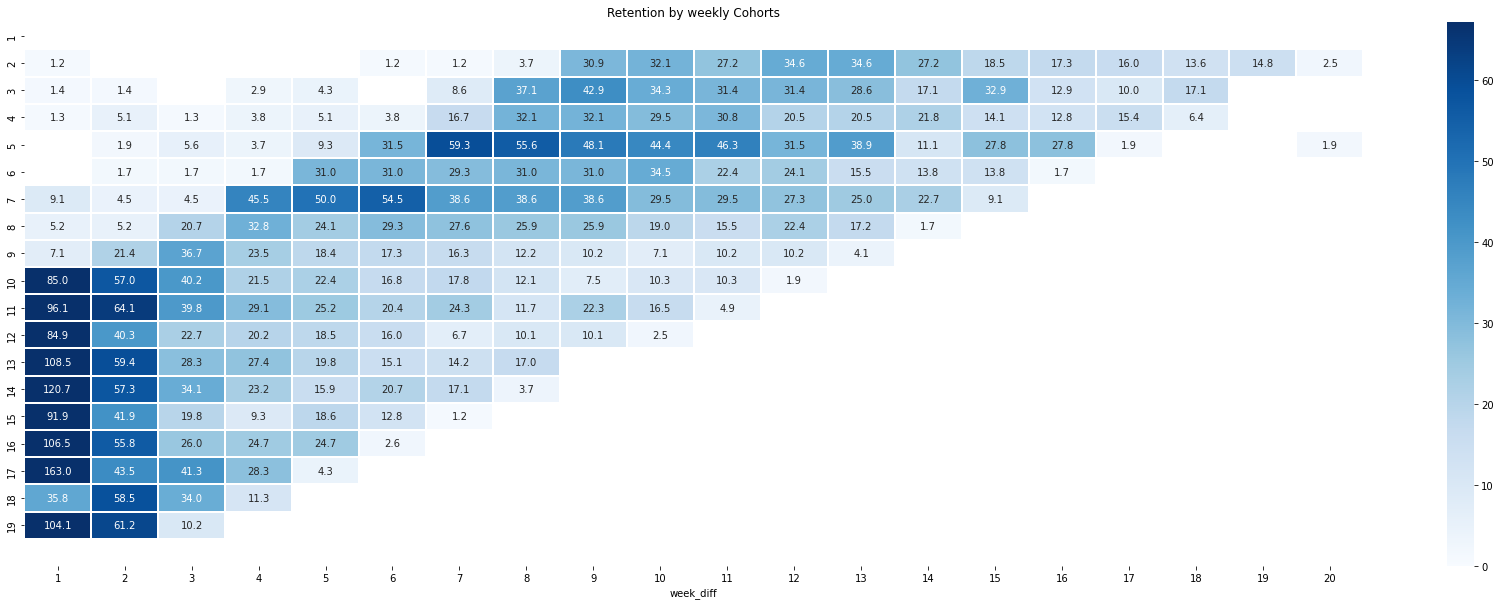

In [327]:
grouping = cohorts_FY22.groupby(['creation_week', 'week_diff'])

# Count the number of unique values per user_id


cohort_data = grouping['user_id'].apply(pd.Series.nunique).reset_index()

# Create a pivot

cohort_counts = cohort_data.pivot(index='creation_week', columns='week_diff', values='user_id')

# Select the first column and store it to cohort_sizes

#cohort_sizes = cohort_counts.iloc[:,0]
grouping2 = cohorts_FY22.groupby(['creation_week'])
cohort_sizes=grouping2["user_id"].apply(pd.Series.nunique).reset_index()["user_id"]
cohorts_list=cohorts_FY22["creation_week"].unique()
cohorts_list.sort()
# Divide the cohort count by cohort sizes along the rows

retention = cohort_counts.divide(cohort_sizes, axis=0)*100
                                 

plt.figure(figsize=(30,10))

# Add a title

plt.title('Retention by weekly Cohorts')

# Create the heatmap

sns.heatmap(data=retention,
annot = True,
cmap = "Blues",
vmin = 0.0,
vmax = list(retention.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
 yticklabels=cohorts_list)
plt.show();